# Analyzing the gradients of the SHT

## Setup

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

from torch_harmonics.quadrature import legendre_gauss_weights, clenshaw_curtiss_weights
from torch_harmonics.legendre import legpoly, clm
from torch_harmonics import RealSHT, InverseRealSHT

## Problem setting

We consider the simple problem of fitting the spectral coefficients $\theta$ such that

$$
\begin{align}
\mathcal{L}
&= ||\mathop{\mathrm{ISHT}}[\theta] - u^*||^2_{S^2} \\
&\approx \sum_j \omega_j (\mathop{\mathrm{ISHT}}[\theta](x_j) - u^*(x_j))^2 \\
&= (S \, \theta - u^*)^T \mathop{\mathrm{diag}}(\omega) \, (S \, \theta - u^*) \\
&= L
\end{align}
$$

is minimized.

The Vandermonde matrix $S$, which is characterized by $\mathop{\mathrm{ISHT}}[\theta] = S \theta$ realizes the action of the discrete SHT.

The necessary condition for a minimizer of $L$ is

$$
\begin{align}
& \nabla_\theta L = S^T \mathop{\mathrm{diag}}(\omega) \, (S \, \theta - u^*) = 0 \\
\Leftrightarrow \quad & S^T \mathop{\mathrm{diag}}(\omega) \, S \; \theta = S^T \mathop{\mathrm{diag}}(\omega) \, u^*.
\end{align}
$$

On the Gaussian grid, 

In [2]:
nlat = 64
nlon = 2*nlat
grid = "equiangular"

# for quadrature and plotting
if grid == "legendre-gauss":
    lmax = mmax = nlat
    xq, wq = legendre_gauss_weights(nlat)
elif grid =="equiangular":
    lmax = mmax = nlat//2
    xq, wq = clenshaw_curtiss_weights(nlat)

sht = RealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)
isht = InverseRealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)

lat = np.arccos(xq)
omega = torch.pi * torch.from_numpy(wq).float() / nlat
omega = omega.reshape(-1, 1)

nlon*omega.sum()

tensor(12.5664)

In [3]:
!wget https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg -O ./data/mola_topo.jpg

import imageio.v3 as iio

img = iio.imread('./data/mola_topo.jpg')
#convert to grayscale
data = np.dot(img[...,:3]/255, [0.299, 0.587, 0.114])
# interpolate onto 512x1024 grid:
data = nn.functional.interpolate(torch.from_numpy(data).unsqueeze(0).unsqueeze(0), size=(nlat,nlon)).squeeze()

/home/bbonev/.zshenv:export:2: not valid in this context: :/usr/local/cuda-11.7/lib64
--2023-10-30 18:00:14--  https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg
Resolving astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)... 137.227.239.81, 2001:49c8:c000:122d::81
Connecting to astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)|137.227.239.81|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 55192 (54K) [image/jpeg]
Saving to: ‘./data/mola_topo.jpg’

./data/mola_topo.jp 100%[===================>]  53.90K   154KB/s    in 0.3s    

2023-10-30 18:00:15 (154 KB/s) - ‘./data/mola_topo.jpg’ saved [55192/55192]



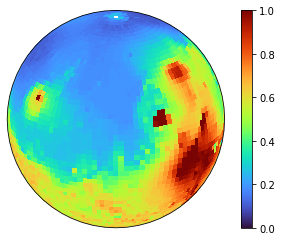

In [4]:
import matplotlib.pyplot as plt
from plotting import plot_sphere

plot_sphere(data, cmap="turbo", colorbar=True)

In [5]:
lr = 1.0
theta = nn.Parameter(torch.randn(lmax, lmax, dtype=torch.complex64))
optim = torch.optim.SGD([theta], lr=lr)

for iter in range(40):
    optim.zero_grad(set_to_none=True)
    loss = torch.sum(0.5*omega*(isht(theta) - data)**2)
    loss.backward()

    # action of the Hessian
    with torch.no_grad():
        for m in range(1,mmax):
            theta.grad[:,m].mul_(0.5)

    optim.step()

    print(f"iter: {iter}, loss: {loss}")

# for iter in range(40):
#     optim.zero_grad(set_to_none=True)
#     loss = torch.sum(0.5*omega*(isht(theta) - data)**2)
#     loss.backward()

#     # action of the Hessian
#     with torch.no_grad():
#         for m in range(1,mmax):
#             theta.grad[:,m].mul_(0.5)
    
#     with torch.no_grad():
#         theta.add_(theta.grad, alpha=-lr)

#     print(f"iter: {iter}, loss: {loss}")

iter: 0, loss: 453.0968931302793
iter: 1, loss: 0.008023964326606358
iter: 2, loss: 0.008023963388341868
iter: 3, loss: 0.008023963340660247
iter: 4, loss: 0.008023963596959654
iter: 5, loss: 0.008023963735337598
iter: 6, loss: 0.008023964260612844
iter: 7, loss: 0.008023964042363394
iter: 8, loss: 0.00802396368406042
iter: 9, loss: 0.008023962714947052
iter: 10, loss: 0.008023963489819921
iter: 11, loss: 0.008023963701078593
iter: 12, loss: 0.008023962923266034
iter: 13, loss: 0.008023964198518512
iter: 14, loss: 0.008023962813486126
iter: 15, loss: 0.008023964110803488
iter: 16, loss: 0.00802396403813473
iter: 17, loss: 0.008023963786036484
iter: 18, loss: 0.008023964195574898
iter: 19, loss: 0.008023963516124565
iter: 20, loss: 0.008023964508201684
iter: 21, loss: 0.008023963767474551
iter: 22, loss: 0.008023963648388185
iter: 23, loss: 0.008023963972575866
iter: 24, loss: 0.008023964038780116
iter: 25, loss: 0.008023963707541834
iter: 26, loss: 0.008023963269911932
iter: 27, loss: 

what's the best possible loss? $\theta^* = (S^T \mathop{\mathrm{diag}}(\omega) \, S)^{-1} S^T \mathop{\mathrm{diag}}(\omega) u^* = \mathop{\mathrm{SHT}}[u^*]$ gives us the global minimizer for this problem.

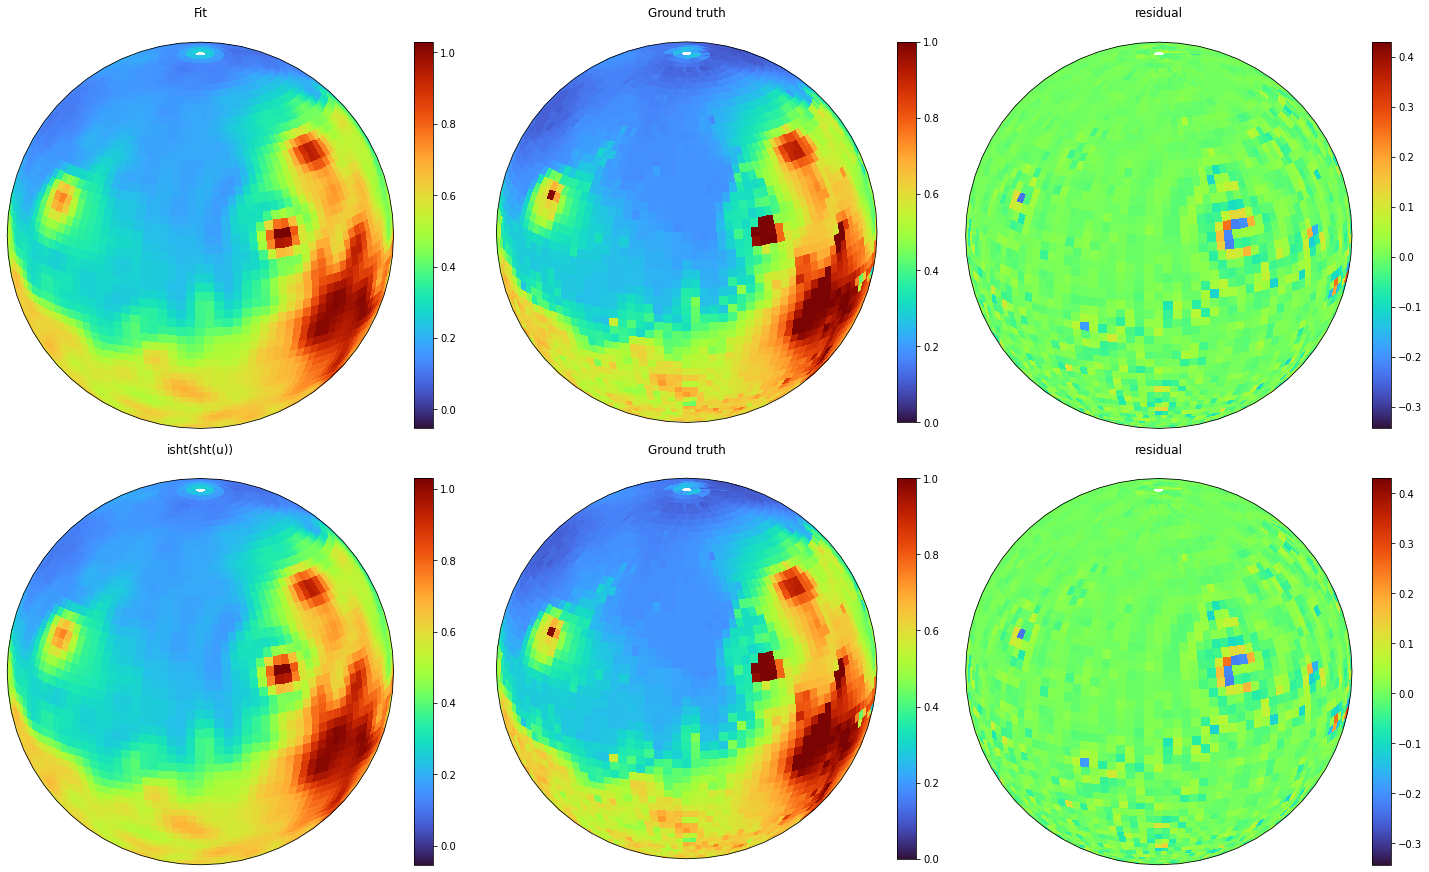

In [6]:
fig = plt.figure(layout='constrained', figsize=(20, 12))
subfigs = fig.subfigures(2, 3)

# spectral fitting
plot_sphere(isht(theta).detach(), fig=subfigs[0,0], cmap="turbo", colorbar=True, title="Fit")
plot_sphere(data, fig=subfigs[0,1], cmap="turbo", colorbar=True, title="Ground truth")
plot_sphere((isht(theta) - data).detach(), fig=subfigs[0,2], cmap="turbo", colorbar=True, title="residual")

# sht(u)
plot_sphere(isht(sht(data)).detach(), fig=subfigs[1,0], cmap="turbo", colorbar=True, title="isht(sht(u))")
plot_sphere(data, fig=subfigs[1,1], cmap="turbo", colorbar=True, title="Ground truth")
plot_sphere((isht(sht(data)) - data).detach(), fig=subfigs[1,2], cmap="turbo", colorbar=True, title="residual")